# Spatial mapping with Tangram

This tutorial demonstrates how to use [Tangram](https://www.nature.com/articles/s41592-021-01264-7) ([original code](https://github.com/broadinstitute/Tangram/)) to map spatial transcriptomics data. Here, we follow the corresponding [tutorial](https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html) at Squidpy. We do not provide much explanation, and instead refer to the original tutorial.

In scvi-tools, the `"cells"` and `"constrained"` modes of Tangram are implemented. In the `"cells"` mode, the priors will need to be calculated manually. We show this below.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import matplotlib.pyplot as plt
import mudata
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import squidpy as sq
from scvi.external import Tangram

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:531: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = partial(_left_exclusive_join_spatialelement_table)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:533: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  inner = partial(_inner_join_spatialelement_table)
/opt/anaconda3/envs/scvi_new/lib/python3.13/s

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Load and preprocess data with squidpy

In [5]:
adata_sp = sq.datasets.visium_fluo_adata_crop("data/visium_fluo_adata_crop.h5ad")
adata_sp = adata_sp[adata_sp.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])].copy()

In [7]:
img = sq.datasets.visium_fluo_image_crop("data")

INFO     Downloading data.tiff from https://exampledata.scverse.org/squidpy/figshare/visium_fluo_image_crop.tiff   


  0%|                                               | 0.00/317M [00:00<?, ?B/s]

In [8]:
adata_sc = sq.datasets.sc_mouse_cortex("data/sc_mouse_cortex.h5ad")

INFO     Downloading sc_mouse_cortex.h5ad from                                                                     
         https://exampledata.scverse.org/squidpy/figshare/sc_mouse_cortex.h5ad                                     


  0%|                                              | 0.00/3.25G [00:00<?, ?B/s]

In [9]:
sc.pp.filter_genes(adata_sp, min_cells=1)
sc.pp.filter_genes(adata_sc, min_cells=1)

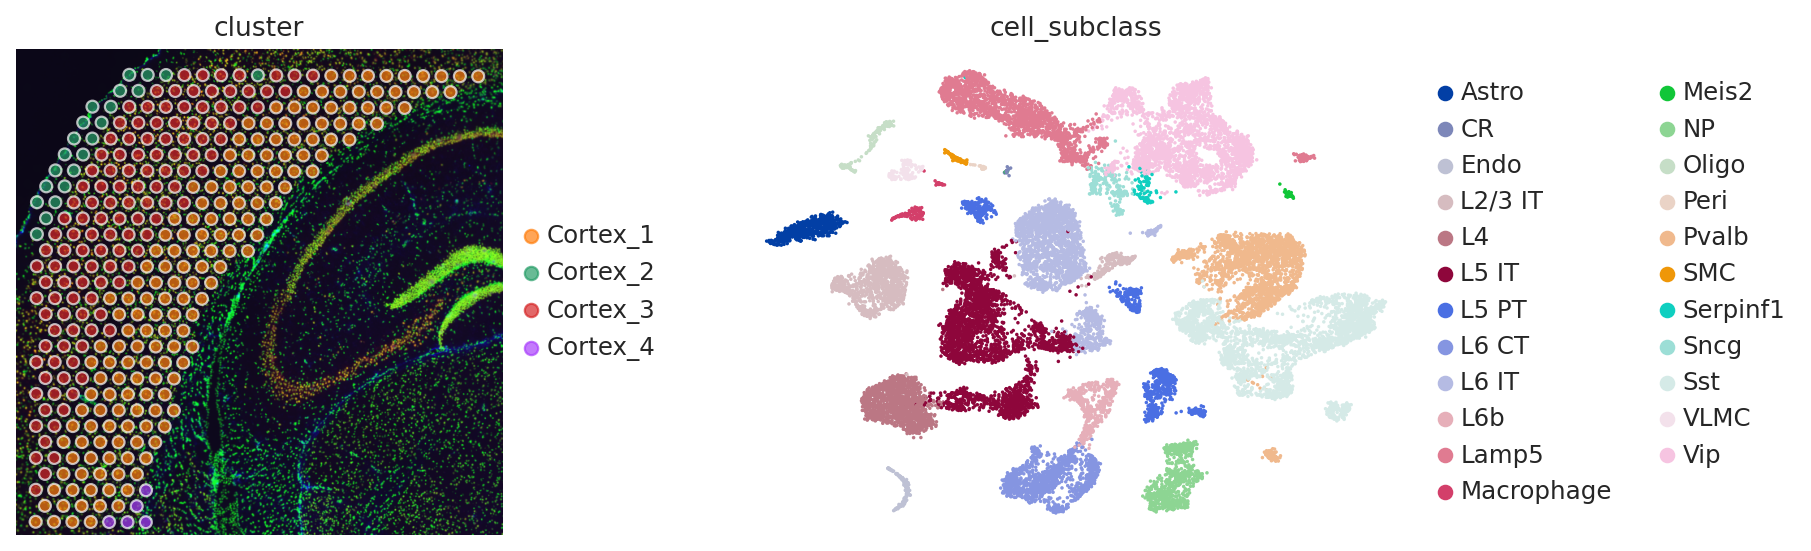

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sq.pl.spatial_scatter(adata_sp, color="cluster", alpha=0.7, frameon=False, ax=axs[0])
sc.pl.umap(adata_sc, color="cell_subclass", size=10, frameon=False, ax=axs[1])

In [11]:
mdata = mudata.MuData(
    {
        "sp": adata_sp,
        "sc": adata_sc,
    }
)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:571: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  self._update_attr_legacy(attr, axis, join_common, **kwargs)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_

In [12]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_sp,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/squidpy/im/_feature_mixin.py:355: RuntimeWarning: invalid value encountered in divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/squidpy/im/_feature_mixin.py:356: RuntimeWarning: invalid value encountered in divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/squidpy/im/_feature_mixin.py:355: RuntimeWarning: invalid value encountered in divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/squidpy/im/_feature_mixin.py:356: RuntimeWarning: invalid value encountered in divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/squidpy/im/_feature_mixin.py:355: RuntimeWarning: invalid value encountered in divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
/opt/anaconda3/envs/scvi_new/lib/python3

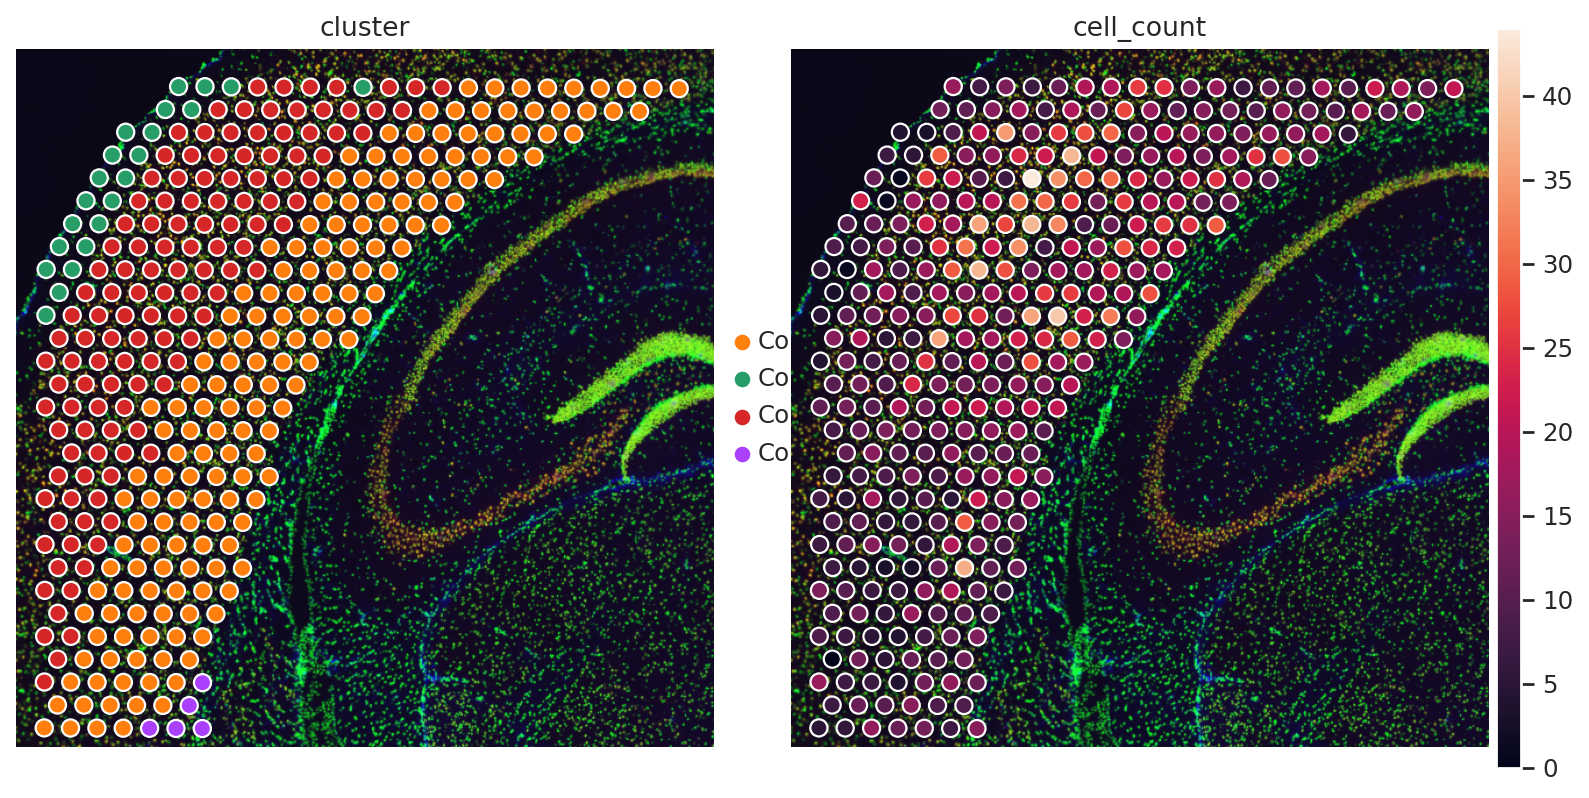

In [13]:
adata_sp.obs["cell_count"] = adata_sp.obsm["image_features"]["segmentation_label"]
sq.pl.spatial_scatter(adata_sp, color=["cluster", "cell_count"], frameon=False, wspace=0.01)

In [14]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:457: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:459: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:462: PerformanceWarning: DataF

### Find genes for mapping

In [15]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_sp.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
len(genes)

1280

### Add training objects to mudata

Here we compute all the density priors we need to run Tangram.

In [18]:
target_count = adata_sp.obs.cell_count.sum()
adata_sp.obs["density_prior"] = np.asarray(adata_sp.obs.cell_count) / target_count
rna_count_per_spot = np.asarray(adata_sp.X.sum(axis=1)).squeeze()
adata_sp.obs["rna_count_based_density"] = rna_count_per_spot / np.sum(rna_count_per_spot)
adata_sp.obs["uniform_density"] = np.ones(adata_sp.X.shape[0]) / adata_sp.X.shape[0]
adata_sp.var_names_make_unique()
mdata.mod["sp"].var_names_make_unique()
mdata.mod["sc"].var_names_make_unique()
mdata.mod["sp_train"] = mdata.mod["sp"][:, genes].copy()
mdata.mod["sc_train"] = mdata.mod["sc"][:, genes].copy()

In [21]:
# global
mdata.var_names = mdata.var_names.astype(str)
mdata.var_names_make_unique()

# per modality
for ad in mdata.mod.values():
    ad.var_names = ad.var_names.astype(str)
    ad.var_names_make_unique()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1348: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr(attr, axis=1 - axis)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1432: UserWarning: Modality names will be prepended to var_names since there are identical var_names in different modalities.
  warnings.warn(
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1348: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var metho

In [22]:
mdata.update()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Run Tangram

Here we run the constrained mode; however, we could have set `constrained=False`, `target_count=None`, and `density_prior_key="rna_count_based_density"` to recover Tangram's `"cells"` mode.

In [24]:
Tangram.setup_mudata(
    mdata,
    density_prior_key="density_prior",
    modalities={
        "density_prior_key": "sp_train",
        "sc_layer": "sc_train",
        "sp_layer": "sp_train",
    },
)
model = Tangram(mdata, constrained=True, target_count=target_count)
model.train()

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
mapper = model.get_mapper_matrix()
mdata.mod["sc"].obsm["tangram_mapper"] = mapper
labels = mdata.mod["sc"].obs.cell_subclass

In [26]:
mdata.mod["sp"].obsm["tangram_ct_pred"] = model.project_cell_annotations(
    mdata.mod["sc"], mdata.mod["sp"], mapper, labels
)
mdata.mod["sp_sc_projection"] = model.project_genes(mdata.mod["sc"], mdata.mod["sp"], mapper)

In [27]:
pred = adata_sp.obsm["tangram_ct_pred"]
if not isinstance(pred, pd.DataFrame):
    pred = pd.DataFrame(pred, index=adata_sp.obs_names)

adata_sp.obs = pd.concat([adata_sp.obs, pred], axis=1)

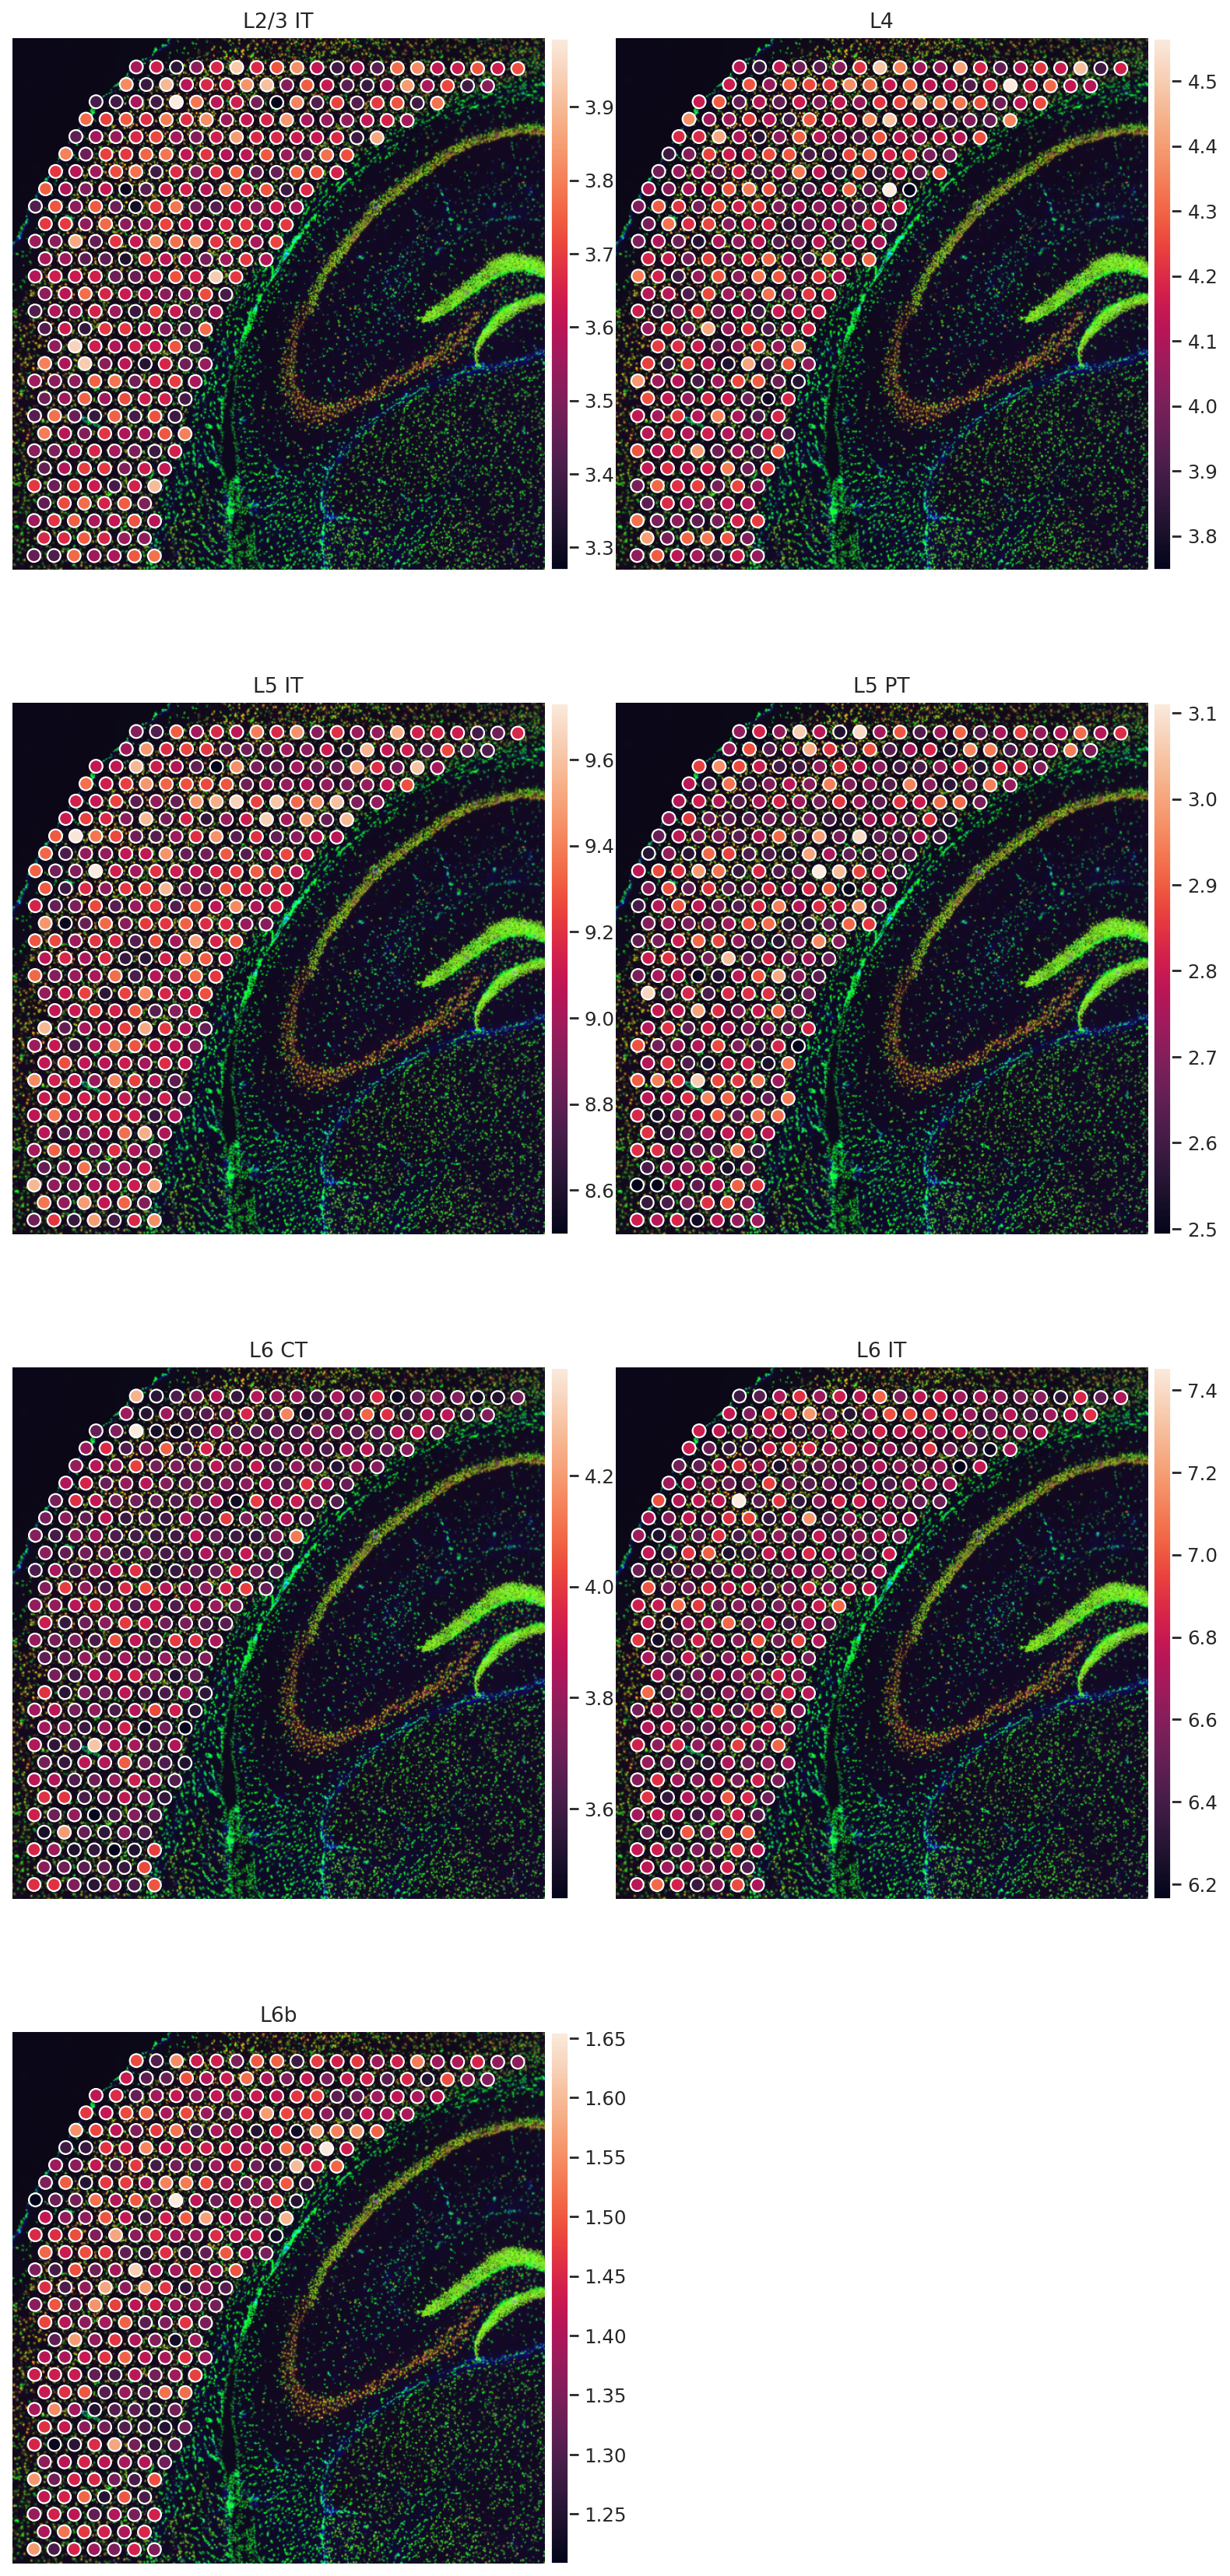

In [28]:
sq.pl.spatial_scatter(
    adata_sp,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
    wspace=0.01,
    ncols=2,
)